In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
train_data = pd.read_csv("../../train.csv")
test_data = pd.read_csv("../../test.csv")

In [3]:
#Removing cols

#removing 'cabin' column because it has many NAN cols
cols = ['Ticket', 'Name', 'Cabin', 'Ticket', 'PassengerId']
train_data.drop(columns=cols, inplace=True)
test_data.drop(columns=cols, inplace=True)

In [4]:
train_data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [5]:
train_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [6]:
#fill NAN
def replace_numeric(columns: list, dataset: pd.DataFrame):
    nan_list = dataset.isnull().any()
    for col in columns:
        if nan_list[col]:
            temp = dataset[col]
            temp = temp.dropna()
            dataset[col].fillna(temp.mean(), inplace=True)

def replace_categorical(columns: list, dataset: pd.DataFrame):
    nan_list = dataset.isnull().any()
    for col in columns:
        if nan_list[col]:
            temp = dataset[col]
            temp = temp.dropna()
            dataset[col].fillna(value=temp.mode()[0], inplace=True)

numeric_cols = ['Age', 'Fare', 'Parch', 'SibSp']
replace_numeric(numeric_cols, train_data)
replace_numeric(numeric_cols, test_data)

categorical_cols = ['Embarked', 'Sex']
replace_categorical(categorical_cols, train_data)
replace_categorical(categorical_cols, test_data)

In [7]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [8]:
test_data.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [9]:
# mapping categorical to numeric
train_data = pd.concat([train_data, pd.get_dummies(train_data['Sex'], dtype=float)], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Sex'], dtype=float)], axis=1)

train_data = pd.concat([train_data, pd.get_dummies(train_data['Embarked'], dtype=float)], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Embarked'], dtype=float)], axis=1)

train_data['Fare'] = train_data['Fare'].map(lambda x: float(x))
test_data['Fare'] = test_data['Fare'].map(lambda x: float(x))

train_data.drop(columns=['Sex', 'Embarked', 'Fare'], inplace=True)
test_data.drop(columns=['Sex', 'Embarked', 'Fare'], inplace=True)

In [10]:
train_data.dtypes

Survived      int64
Pclass        int64
Age         float64
SibSp         int64
Parch         int64
female      float64
male        float64
C           float64
Q           float64
S           float64
dtype: object

In [11]:
test_data.dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
female    float64
male      float64
C         float64
Q         float64
S         float64
dtype: object

In [12]:
train_data

,Survived,Pclass,Age,SibSp,Parch,female,male,C,Q,S
0,0,3,22.000000,1,0,0.0,1.0,0.0,0.0,1.0
1,1,1,38.000000,1,0,1.0,0.0,1.0,0.0,0.0
2,1,3,26.000000,0,0,1.0,0.0,0.0,0.0,1.0
3,1,1,35.000000,1,0,1.0,0.0,0.0,0.0,1.0
4,0,3,35.000000,0,0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,0.0,1.0,0.0,0.0,1.0
887,1,1,19.000000,0,0,1.0,0.0,0.0,0.0,1.0
888,0,3,29.699118,1,2,1.0,0.0,0.0,0.0,1.0
889,1,1,26.000000,0,0,0.0,1.0,1.0,0.0,0.0


In [13]:
#spillitng data
x_train = train_data.drop(columns='Survived')
y_train = train_data['Survived']
x_test = test_data

In [14]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

Text(70.5, 0.5, 'Variable 1')

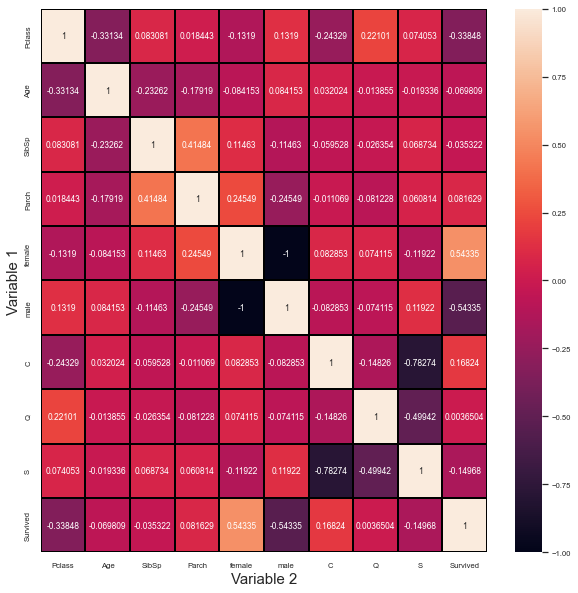

In [15]:
# Correlation Coefficient Matrix
import seaborn as sns
import matplotlib.pyplot as plt

full_set = pd.concat([x_train, y_train], axis=1)
plt.figure(figsize=(len(full_set.columns), len(full_set.columns)), facecolor='w', edgecolor='k')
sns.set(font_scale=0.7)
sns.heatmap(full_set.corr(),
            annot=True,
            fmt='.5g',
            linewidths=2,
            linecolor='black')
plt.xlabel('Variable 2',fontsize=15)
plt.ylabel('Variable 1',fontsize=15)

In [16]:
# removing columns after getting correlation matrix

cols = ['Q', 'Parch']
x_train.drop(columns=cols, inplace=True)
x_test.drop(columns=cols, inplace=True)

In [17]:
#Logistic Regression
class LogisticRegression:
    def __init__(self):
        self.weight = None

    def fit(self, x:pd.DataFrame, y:pd.DataFrame, epoch:int, learning_rate:float):
        m = len(x)
        if x.iloc[0, 0] != 1:
            x.insert(0, 'bias', 1)

        self.weight = np.ones(len(x.columns))

        for i in range(epoch):
            prediction = self.__logistic_function(pd.Series(np.dot(x, self.weight)))
            gradient = 1/m * x.T.dot(prediction - y)
            self.weight = self.weight - learning_rate * gradient

    def predict(self, df:pd.DataFrame, threshold:float=0.5):
        if df.iloc[0, 0] != 1:
            df.insert(0, 'bias', 1)
        probabilities = self.__logistic_function(pd.Series(np.dot(df, self.weight)))
        return probabilities.map(lambda x: 1 if x >= threshold else 0)

    @classmethod
    def __logistic_function(cls, vector: pd.Series):
        return vector.map(lambda x: 1/(1 + np.exp(-x)))

In [18]:
lr_reg = LogisticRegression()
lr_reg.fit(x_train, y_train, epoch=200, learning_rate=0.09)
y_train_pred = lr_reg.predict(x_train)

y_train_pred

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Length: 891, dtype: int64

In [19]:
#training data evaluation

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

accuracy = accuracy_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
f1_score = f1_score(y_train, y_train_pred)

errors = pd.DataFrame({'Value': [accuracy, recall, precision, f1_score]}, index=['Accuracy', 'Recall', 'Precision', 'F1-score'])

errors

,Value
Accuracy,0.786756
Recall,0.681287
Precision,0.742038
F1-score,0.710366


<AxesSubplot:>

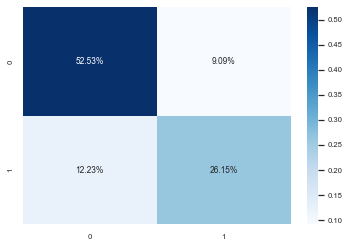

In [20]:
# showing confiusion matrix
from sklearn.metrics import confusion_matrix
cm_matrix = confusion_matrix(y_train, y_train_pred)

sns.heatmap(cm_matrix/np.sum(cm_matrix), annot=True, fmt='.2%', cmap='Blues')

In [21]:
#prediction of test set
y_test_pred = pd.DataFrame()
y_test_pred['Survived'] = lr_reg.predict(x_test)

In [22]:
#submission of answer
test_col = pd.read_csv("../../test.csv")['PassengerId']
y_test_pred = pd.concat([test_col, y_test_pred], axis=1)

y_test_pred.to_csv('../../titanic_submission.csv', index=False)
y_test_pred

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
#Saving CSV files
test_predictions = y_test_pred.drop(columns='PassengerId')
test_predictions.to_csv('../../Q1.csv', index=False)

In [26]:
#Saving CSV files
test_predictions = y_test_pred.drop(columns='PassengerId')
test_predictions.to_csv('../../Q1.csv', index=False)